In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm

plt.style.use("ggplot")
%load_ext autoreload
%autoreload 2

In [2]:
data_folder = "data/"

In [3]:
from utils import reduce_mem_usage, WellLogsProcessing, plot_features_importance, penalty_score

In [4]:
dest_file = data_folder + "train.csv"
train_df = pd.read_csv(data_folder + "train.csv",sep=";")

In [5]:
train_df,na = reduce_mem_usage(train_df)

Memory usage of properties dataframe is : 258.9785385131836  MB
******************************
Column:  DEPTH_MD
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  X_LOC
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  Y_LOC
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  Z_LOC
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  CALI
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  RSHA
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  RMED
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  RDEP
dtype before:  float64
dtype after:  

## Splitting data per well.

In [6]:
### get train wells and fit imputer on them
###93000 is only in well 16/4-1
all_lith  = train_df.FORCE_2020_LITHOFACIES_LITHOLOGY.unique()
all_wells  = train_df.WELL.unique()

###Keep 4 wells for val/test sets
val_wells = ["16/10-1","16/2-16"]
test_wells = ["16/11-1 ST3","34/3-1 A"]
train_wells = [well_name for well_name in all_wells if well_name not in val_wells+test_wells]

In [7]:
full_df = train_df.loc[train_df.WELL.isin(train_wells),:]

## data processing

Features selection have been done from data_analysis notebooks. Those features are either very discriminative or with very few null values.

In [8]:
numeric_features = ['RMED', 'RDEP', 'RHOB', 'GR', 'NPHI','DTC','RXO','RSHA',
                    "X_LOC","Y_LOC","Z_LOC",'DEPTH_MD']
# numeric_features = ['RMED', 'RDEP', 'RHOB', 'GR', 'NPHI','DTC',"X_LOC","Y_LOC","Z_LOC",'DEPTH_MD']
# numeric_features = ['RMED', 'RDEP','DRHO','CALI',
#                     'RHOB', 'GR', 'NPHI','DTC',"DTS",'PEF','SP','RXO','RSHA',
#                     "RMIC","X_LOC","Y_LOC","Z_LOC",'DEPTH_MD']

cat_features = ['GROUP','FORMATION']

others_numeric=[]

all_formations = list(full_df.FORMATION.unique())
all_formations.remove(np.nan)
all_formations = sorted(all_formations)

all_groups = list(full_df.GROUP.unique())
all_groups.remove(np.nan)
all_groups = sorted(all_groups)

#### Instanciate Logs Processing pipeline. Here we will only fill numerical empty values
logs_processor = WellLogsProcessing(numeric_features ,cat_features ,
                                    others_numeric,all_formations ,all_groups,
                                    remove_outliers=False,process_num_features=True,
                                      impute_categorical = False, encode_categorical=False)

In [9]:
######### Numerical features empty values imputation and scaling
filled_full_data = logs_processor.get_processed_data(full_df.loc[:,full_df.columns],is_train_data=True)

Fitting iterative imputer
[IterativeImputer] Completing matrix with shape (1125622, 12)
[IterativeImputer] Change: 103628.125, scaled tolerance: 6856.661 
[IterativeImputer] Change: 336598.71875, scaled tolerance: 6856.661 
[IterativeImputer] Change: 153881.625, scaled tolerance: 6856.661 
[IterativeImputer] Change: 52670.0859375, scaled tolerance: 6856.661 
[IterativeImputer] Change: 151230.25, scaled tolerance: 6856.661 
[IterativeImputer] Change: 121455.234375, scaled tolerance: 6856.661 
[IterativeImputer] Change: 217391.984375, scaled tolerance: 6856.661 
[IterativeImputer] Change: 113505.203125, scaled tolerance: 6856.661 
[IterativeImputer] Change: 159394.984375, scaled tolerance: 6856.661 
[IterativeImputer] Change: 85204.2265625, scaled tolerance: 6856.661 


/data/pau117/STAGIAIRES/YANKWA/conda/envs/leyanki_tf/lib/python3.7/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


[IterativeImputer] Completing matrix with shape (1125622, 12)
Fitting data scaler


In [10]:
filled_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1125622 entries, 0 to 1170510
Data columns (total 15 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   RMED       1125622 non-null  float64
 1   RDEP       1125622 non-null  float64
 2   RHOB       1125622 non-null  float64
 3   GR         1125622 non-null  float64
 4   NPHI       1125622 non-null  float64
 5   DTC        1125622 non-null  float64
 6   RXO        1125622 non-null  float64
 7   RSHA       1125622 non-null  float64
 8   X_LOC      1125622 non-null  float64
 9   Y_LOC      1125622 non-null  float64
 10  Z_LOC      1125622 non-null  float64
 11  DEPTH_MD   1125622 non-null  float64
 12  GROUP      1124344 non-null  object 
 13  FORMATION  998829 non-null   object 
 14  WELL       1125622 non-null  object 
dtypes: float64(12), object(3)
memory usage: 137.4+ MB


## GROUP,FEATURE PREDICTION
Now we will predict GROUP AND FORMATION features instead of just imputing them with the mode value.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from utils import predict_target, get_predictor

In [12]:
### GROUP prediction. We define predictors, classifier and we train and predict GROUP feature

group_predictors = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC','RMED', 'RDEP', 'RHOB', 'GR', 'NPHI',
                       'DTC',"RSHA"]
catboost_classifier = CatBoostClassifier(iterations=500,learning_rate=0.1,depth = 4,
                                            min_data_in_leaf = 50,
                                             bagging_temperature = 10,
                                            grow_policy = 'Depthwise',objective='MultiClassOneVsAll',
                                            custom_metric = ['Accuracy'],
                                            early_stopping_rounds = 100,task_type='GPU',
                                            train_dir = data_folder)
filled2, group_imputer, group_predictors_scaler = get_predictor(filled_full_data.loc[:,filled_full_data.columns],
                                                                  catboost_classifier,
                                                                   target='GROUP',regressors=group_predictors)

0:	learn: 0.6135676	test: 0.6135365	best: 0.6135365 (0)	total: 11.2ms	remaining: 5.57s
10:	learn: 0.2618543	test: 0.2617322	best: 0.2617322 (10)	total: 111ms	remaining: 4.92s
20:	learn: 0.1657779	test: 0.1656400	best: 0.1656400 (20)	total: 205ms	remaining: 4.68s
30:	learn: 0.1351343	test: 0.1349535	best: 0.1349535 (30)	total: 298ms	remaining: 4.51s
40:	learn: 0.1191061	test: 0.1189453	best: 0.1189453 (40)	total: 385ms	remaining: 4.31s
50:	learn: 0.1098510	test: 0.1096548	best: 0.1096548 (50)	total: 472ms	remaining: 4.16s
60:	learn: 0.1035811	test: 0.1034252	best: 0.1034252 (60)	total: 563ms	remaining: 4.05s
70:	learn: 0.0989810	test: 0.0988554	best: 0.0988554 (70)	total: 649ms	remaining: 3.92s
80:	learn: 0.0954795	test: 0.0953831	best: 0.0953831 (80)	total: 738ms	remaining: 3.82s
90:	learn: 0.0922658	test: 0.0921882	best: 0.0921882 (90)	total: 840ms	remaining: 3.77s
100:	learn: 0.0897679	test: 0.0897120	best: 0.0897120 (100)	total: 924ms	remaining: 3.65s
110:	learn: 0.0873501	test: 0.0

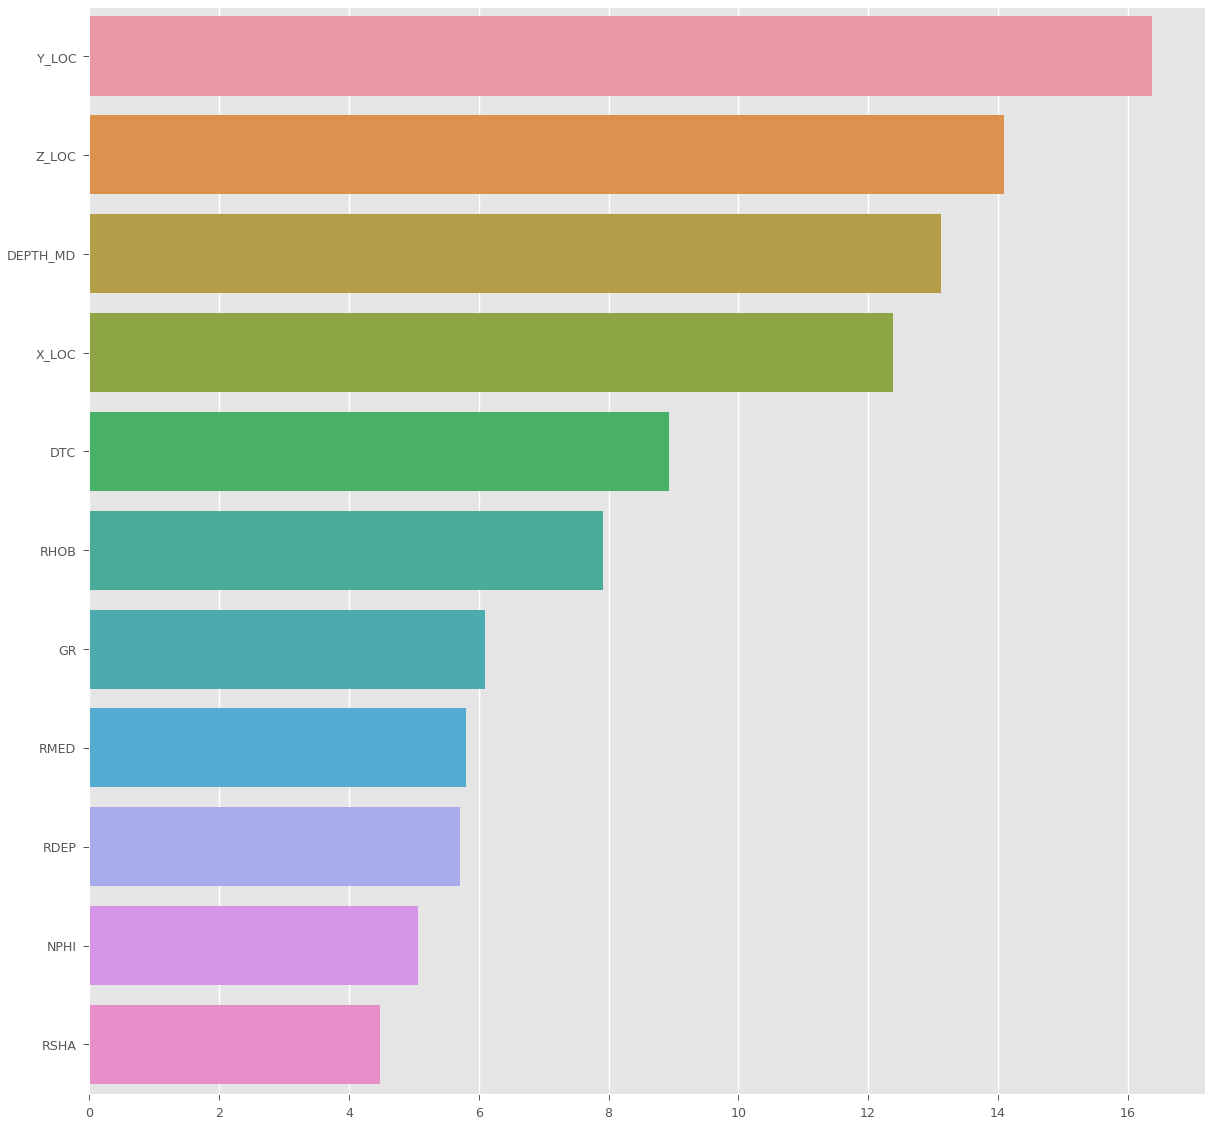

In [13]:
plot_features_importance(group_imputer.feature_importances_,group_imputer.feature_names_,figsize=(20,20))

- We splitted samples having a non null GROUP feature in train/val sets.
- After training, our GROUP classifier is accurate at 88% on val set. So we can use it to impute GROUP feature

In [14]:
filled2["enc_GROUP"] = filled2.GROUP.map(all_groups.index).astype(int).astype("category")

In [15]:
### FORMATION prediction. We define predictors, classifier and we train and predict FORMATION feature
formation_predictors = ['DEPTH_MD',"enc_GROUP", 'X_LOC', 'Y_LOC', 'Z_LOC','RMED', 'RDEP', 'RHOB', 'GR', 'NPHI',
                       'DTC',"RSHA"]

target = "FORMATION"
cat_1 = formation_predictors.index("enc_GROUP")
encoded_cat = ["enc_GROUP"]

catboost_classifier = CatBoostClassifier(iterations=800,learning_rate=0.1,depth = 4,
                                            min_data_in_leaf = 50,
                                            bagging_temperature = 10,
                                            cat_features = [cat_1],
                                            grow_policy = 'Depthwise',objective='MultiClass',
                                            custom_metric = ['Accuracy'],
                                            early_stopping_rounds = 100,task_type='GPU',
                                            train_dir = data_folder)
filled3, formation_imputer, formation_predictors_scaler = get_predictor(filled2.loc[:,filled2.columns],
                                                                  catboost_classifier,
                                                                   target=target,
                                                                regressors=formation_predictors,
                                                                           encoded_cat=encoded_cat)

0:	learn: 2.7765940	test: 2.7789198	best: 2.7789198 (0)	total: 334ms	remaining: 4m 27s
10:	learn: 1.9085548	test: 1.9124003	best: 1.9124003 (10)	total: 3.59s	remaining: 4m 17s
20:	learn: 1.6234507	test: 1.6273141	best: 1.6273141 (20)	total: 6.84s	remaining: 4m 13s
30:	learn: 1.4680277	test: 1.4720848	best: 1.4720848 (30)	total: 10.1s	remaining: 4m 9s
40:	learn: 1.3296694	test: 1.3334583	best: 1.3334583 (40)	total: 13.3s	remaining: 4m 5s
50:	learn: 1.2300239	test: 1.2337159	best: 1.2337159 (50)	total: 16.6s	remaining: 4m 3s
60:	learn: 1.1486738	test: 1.1516964	best: 1.1516964 (60)	total: 19.8s	remaining: 3m 59s
70:	learn: 1.0996774	test: 1.1029074	best: 1.1029074 (70)	total: 23s	remaining: 3m 56s
80:	learn: 1.0576672	test: 1.0609767	best: 1.0609767 (80)	total: 26.2s	remaining: 3m 52s
90:	learn: 1.0132553	test: 1.0164015	best: 1.0164015 (90)	total: 29.5s	remaining: 3m 49s
100:	learn: 0.9661177	test: 0.9691423	best: 0.9691423 (100)	total: 32.7s	remaining: 3m 46s
110:	learn: 0.9394888	test

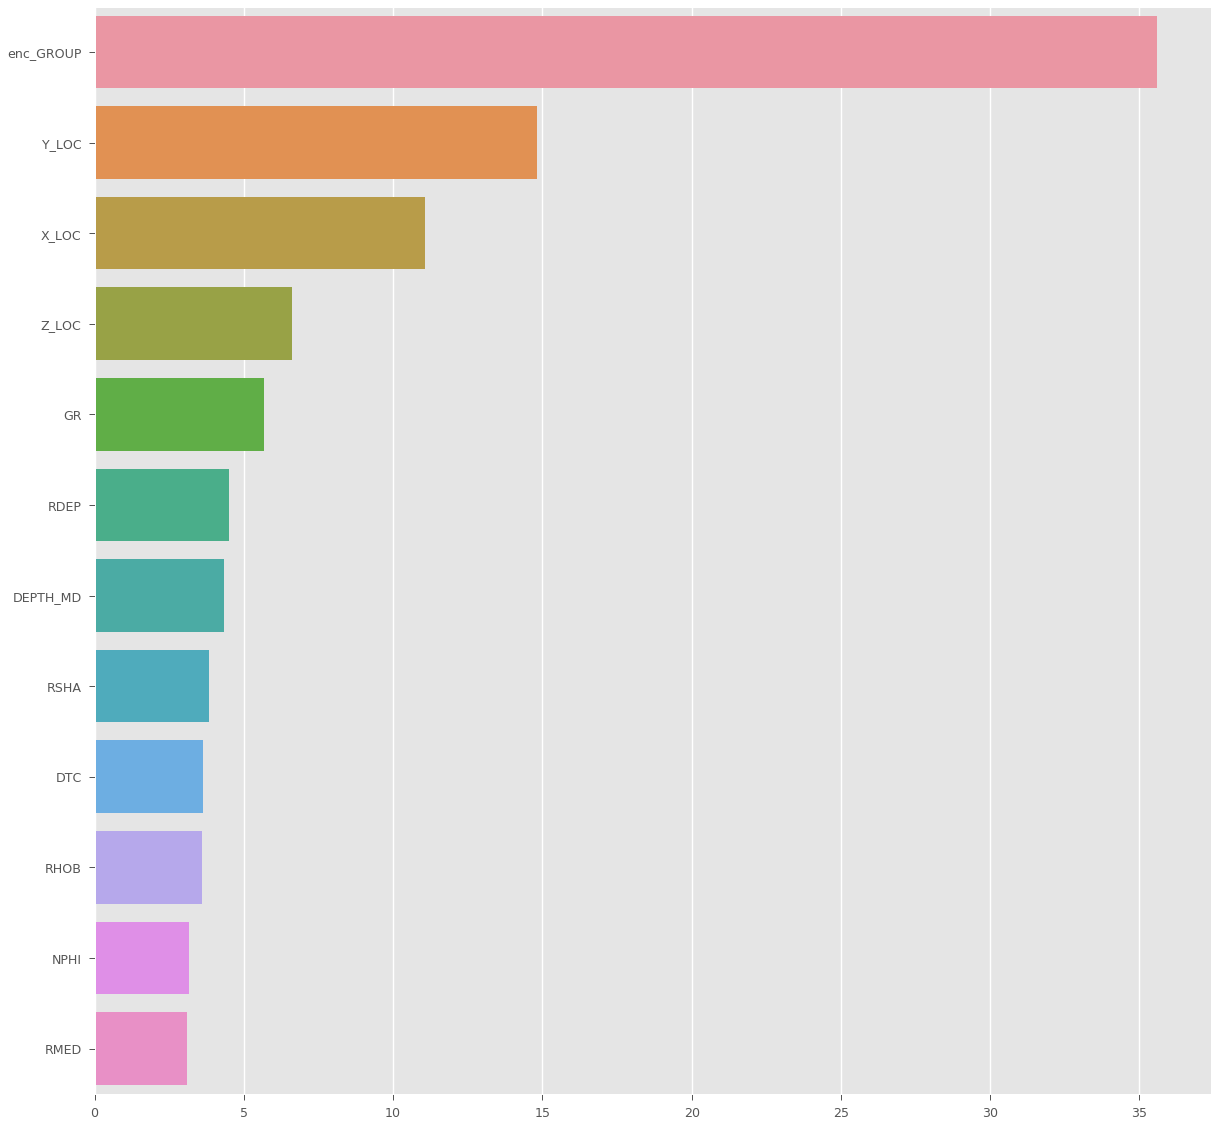

In [16]:
plot_features_importance(formation_imputer.feature_importances_,
                         formation_imputer.feature_names_,figsize=(20,20))

In [17]:
mask = filled2.FORMATION.notna()
num_features = list(set(formation_predictors) - set(encoded_cat))
vali  = filled2.loc[mask,num_features]
vali[vali.columns] = formation_predictors_scaler.transform(vali)
vali[encoded_cat] = filled2.loc[mask,encoded_cat]
print("Accuracy of FORMATION classifier is : ",accuracy_score(filled2.loc[mask,"FORMATION"].values,
                                              formation_imputer.predict(vali[formation_predictors])))


Accuracy of FORMATION classifier is :  0.6607257098061831


## Final step
fill null values for train/val/test sets

In [18]:
##let's fill the whole dataset and save everything
filled_whole = logs_processor.get_processed_data(train_df.loc[:,train_df.columns])

[IterativeImputer] Completing matrix with shape (1170511, 12)


In [19]:
##fill GROUP
filled_whole2 = filled_whole.loc[:,filled_whole.columns]
mask = filled_whole2.GROUP.isna()
if mask.any():
    vali = group_predictors_scaler.transform(filled_whole2.loc[mask,group_predictors])
    filled_whole2.loc[mask,"GROUP"] = group_imputer.predict(vali)

In [20]:
## fill FORMATION
filled_whole2["enc_GROUP"] = filled_whole2.GROUP.map(lambda x: logs_processor.all_groups.get(x,1000)).astype(int).astype("category")

filled_whole3 = filled_whole2.loc[:,filled_whole2.columns]

encoded_cat = ["enc_GROUP"]
num_features = list(set(formation_predictors) - set(encoded_cat))


mask = filled_whole3.FORMATION.isna()
if mask.any():
    vali  = filled_whole3.loc[mask,num_features]
    vali[vali.columns] = formation_predictors_scaler.transform(vali)
    vali[encoded_cat] = filled_whole3[encoded_cat]
    filled_whole3.loc[mask,"FORMATION"] = formation_imputer.predict(vali[formation_predictors])

## Saving 
Now we save processed data and processing pipeline.

In [21]:
 from joblib import dump, load

In [22]:
filled_whole3.loc[:,['FORCE_2020_LITHOFACIES_LITHOLOGY','FORCE_2020_LITHOFACIES_CONFIDENCE']] = train_df.loc[:,['FORCE_2020_LITHOFACIES_LITHOLOGY','FORCE_2020_LITHOFACIES_CONFIDENCE']]

In [23]:
filled_whole3,na = reduce_mem_usage(filled_whole3.drop(columns="enc_GROUP"))

Memory usage of properties dataframe is : 142.884765625  MB
******************************
Column:  RMED
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  RDEP
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  RHOB
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  GR
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  NPHI
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  DTC
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  RXO
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  RSHA
dtype before:  float64
dtype after:  float32
*******

In [24]:
#### All features are filled. The only exception is FORCE_2020_LITHOFACIES_CONFIDENCE 
#but it doesn't matter since we are not using 
filled_whole3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170511 entries, 0 to 1170510
Data columns (total 17 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   RMED                               1170511 non-null  float32
 1   RDEP                               1170511 non-null  float32
 2   RHOB                               1170511 non-null  float32
 3   GR                                 1170511 non-null  float32
 4   NPHI                               1170511 non-null  float32
 5   DTC                                1170511 non-null  float32
 6   RXO                                1170511 non-null  float32
 7   RSHA                               1170511 non-null  float32
 8   X_LOC                              1170511 non-null  float32
 9   Y_LOC                              1170511 non-null  float32
 10  Z_LOC                              1170511 non-null  float32
 11  DEPTH_MD                

In [25]:
filled_whole3.to_csv(data_folder+"filled_train.csv",index=False)

In [26]:
logs_processor.save_processing_params(data_folder=data_folder)

In [27]:
###### Save GROUP classifier
group_name = "group_imputer"
group_dict = {}
group_dict["predictors"] = group_predictors
group_dict["imputer"] = group_imputer
group_dict["scaler"] = group_predictors_scaler

dump(group_dict,data_folder+group_name+".joblib")

###### Save FORMATION classifier
formation_name = "formation_imputer"
formation_dict = {}
formation_dict["predictors"] = formation_predictors
formation_dict["imputer"] = formation_imputer
formation_dict["scaler"] = formation_predictors_scaler

dump(formation_dict,data_folder+formation_name+".joblib")

['data/formation_imputer.joblib']

This is the end of data processing. We did null values imputation, categorical features encoding and numeric features scaling. 